In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
data_dir = 'data'
image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_to_idx[class_name])

train_paths,test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                     labels, test_size=0.2,
                                                                     stratify=labels,
                                                                     random_state=42)

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [9]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

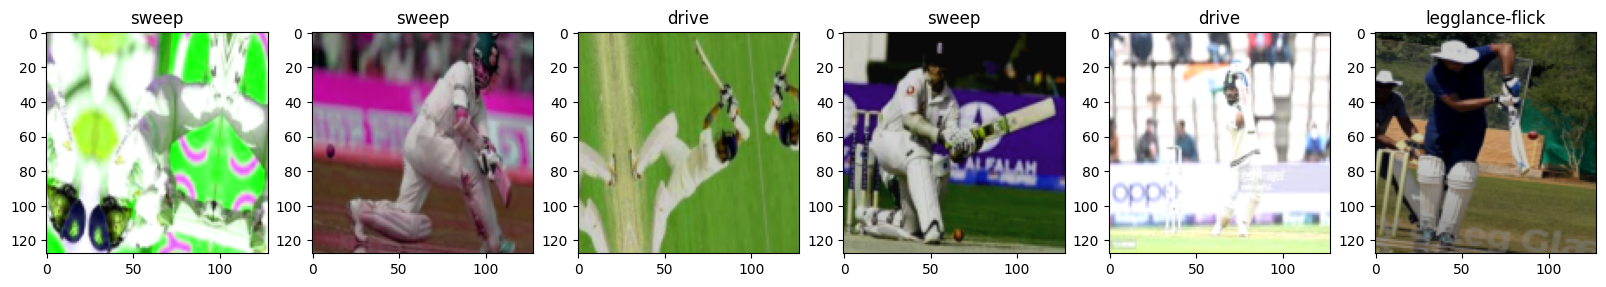

In [10]:
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, label = dataset[i]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[label])
    plt.show()

show_images(train_dataset)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

c:\Users\mubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\mubas/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:16<00:00, 6.07MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.7217
Epoch 2, Loss: 0.4451
Epoch 3, Loss: 0.1939
Epoch 4, Loss: 0.1831
Epoch 5, Loss: 0.2658
Epoch 6, Loss: 0.2836
Epoch 7, Loss: 0.1345
Epoch 8, Loss: 0.0550
Epoch 9, Loss: 0.2517
Epoch 10, Loss: 0.0386
Epoch 11, Loss: 0.0634
Epoch 12, Loss: 0.0398
Epoch 13, Loss: 0.1010
Epoch 14, Loss: 0.1726
Epoch 15, Loss: 0.0743
Epoch 16, Loss: 0.0225
Epoch 17, Loss: 0.1433
Epoch 18, Loss: 0.1447
Epoch 19, Loss: 0.0298
Epoch 20, Loss: 0.0083


In [13]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


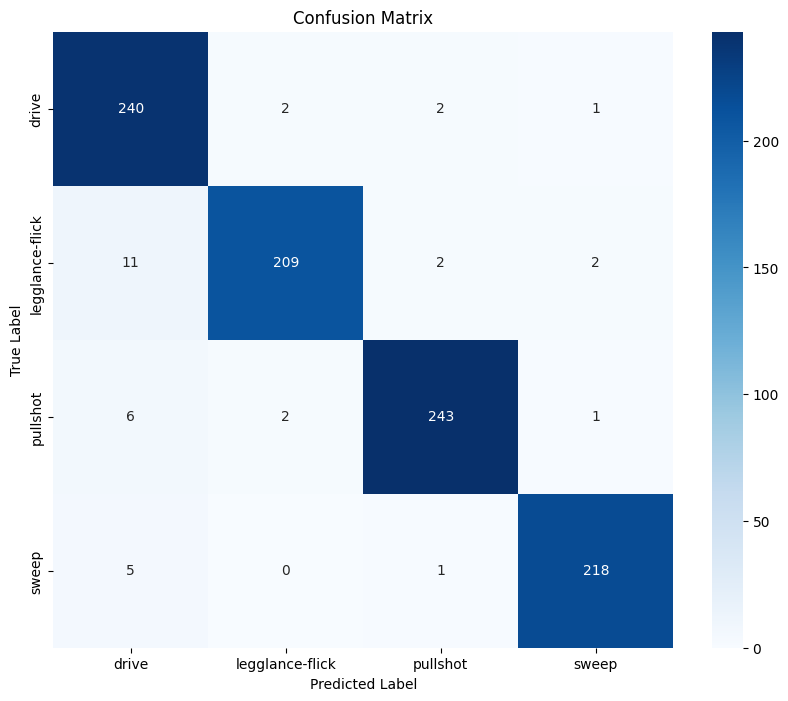

In [14]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

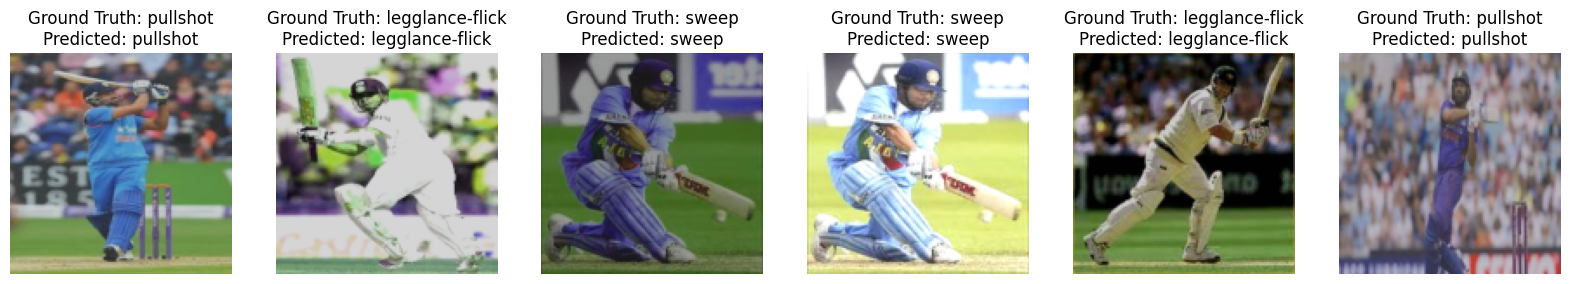

In [15]:
def show_predictions(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, true_label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()

        ax = axes[i]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu())
        ax.set_title(f"Ground Truth: {class_names[true_label]}\nPredicted: {class_names[pred_label]}")
        ax.axis('off')
    plt.show()

show_predictions(test_dataset)